# Deep DealWithIt

### (•_•)
### ( •_•)>⌐■-■
### (⌐■_■)


This project is based off of the wonderful post by Gabriel Goh, [Decoding the Thought Vector](http://gabgoh.github.io/ThoughtVectors/). My original idea was to train a Variational Autoencoder with [Discriminative Regularization (DR)](https://arxiv.org/abs/1602.03220) on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset along with random images from the internet, then use a classifier to locate "sunglasses thought vector", and apply that to input images. See the sliders under [Facial Hair and Accessories](http://gabgoh.github.io/ThoughtVectors/#morph_angle), third row, to see what I mean.

Unfortunately, I ran into a lot of issues with propagating gradients through very deep VAEs. [This is a known problem with VAEs due to the stochastic layer](https://arxiv.org/abs/1602.02282), and I'm working on getting a Keras implementation of the ladder architecture, but I reckon it won't be ready for the deadline.

My plan is: 
1. Rough it out on MNIST
2. Further develop and refine on CIFAR, and then once I've dialed in the DR functionality...
3. Train it on Celeb A. 
4. ???
5. PROFIT!

I got as far as 2 and a half. But I think the idea of feature vector manipulation is insanely cool, so I'll probably keep hacking away at this for a while. 

### Note on warmup
** Warmup ** is a [technique to improve VAE training](http://orbit.dtu.dk/files/121765928/1602.02282.pdf). The loss function of VAEs consist of two terms: 
1. Reconstruction loss (binary crossentropy of the input image and the generated image)
2. Divergence loss (Kullback-Leibler divergence (KLD) of the stochastic latent Z variable)
(1) ensures that the generated image looks like the input image, and (2) esures that the latent Z variable stays (roughly) normal distribution. Warmup decreases the weight of divergence loss at the start of training. My understanding is that the deep convolutional layers need time to "burn in", i.e. settle in on filter weights representing useful edges, shapes, abstractions, etc. Weighing KLD too early interferes with the development of useful filters, so we slowly increase the contribution of KLD loss over the course of training. This technique is pretty cutting edge, and seems to be very fiddly and prone to make the model do weird things when not set perfectly correctly by trial-and-error. 

In [1]:
import os 
# os.environ['KERAS_BACKEND'] = 'theano'
import keras
print(keras.__version__)
from tensorflow import test
test.is_gpu_available()

Using TensorFlow backend.


2.0.2


True

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [50]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal, ndimage, misc

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise
from keras.layers import Activation
from keras.layers import Conv2D, Deconv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv3D, UpSampling3D, MaxPooling3D
from keras.layers import merge
from keras.models import Model
from keras import regularizers
from keras import backend as K_backend
from keras import objectives

import models_basic

from keras_tqdm import TQDMNotebookCallback

from autoencoder import VAE_MNIST_0

In [4]:
from keras.datasets import cifar10, mnist
from keras.utils import np_utils

In [18]:
import keras.utils

In [73]:
def redim(ary, ndim=4):
    if ary.ndim == 4: 
        w, x, y, z = ary.shape
    if ary.ndim == 3:
        w, x, y = ary.shape
        z = 1
    if ary.ndim == 2:
        w, x = ary.shape
        y, z, = 1, 1
    if ndim==4:
        return ary.reshape((w, x, y, z))
    if ndim==3:
        return ary.reshape((w, x, y))
    if ndim==2:
        return ary.reshape((w, x))

#### Select a dataset. If we use MNIST, pad it out so it's a power of 2. The network expects a shape (N x M), where N and M are powers of two
Also, we need to reshape MNIST since it is single channel. 

In [328]:
dataset = 'cifar'
if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.pad(x_train, ((0,0), (2,2), (2,2)), 'edge')
    x_test = np.pad(x_test, ((0,0), (2,2), (2,2)), 'edge')
if dataset == 'cifar':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    
if x_train.ndim == 3:
    s = x_train.shape
    x_train = x_train.reshape((len(x_train), s[1], s[2], 1))
    x_test = x_test.reshape((len(x_test), s[1], s[2], 1))
original_img_size = x_train[0].shape
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


#### For the Discriminative Regeneration, we would need to use a loss term which contains categorical information
This currently isn't operational, so we don't actually need it at the moment

In [329]:
y_train_oh = np.asarray(np_utils.to_categorical(y_train), 'float32')
y_test_oh = np.asarray(np_utils.to_categorical(y_test), 'float32')

print(y_train_oh.shape)

(50000, 10)


# OOP, there it is!
I really love using subclasses in Python to build up layers of abstraction. Since VAE is just a more sophisticated form of autoencoder, we can subclass our general purpose Autoencoder class, and add the machinery necessary to make it a VAE. And since Discriminative VAE is just a more specialized VAE, we can add the regularization secret sauce to this subclass. 

In [330]:
class Autoencoder(models_basic.SaveableModel):
    """
    Base class for all-purpose autoencoder. VAE, CNN-AE, etc will be built off of this.

    Input -> Encoder -> Z Latent Vector -> Decoder -> Output
    """
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100, # size of minibatch
                 compile_decoder=False # create the decoder. Not necessary for every use case
                 ):
        self.model = None
        self.encoder = None
        self.decoder = None
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.compile_decoder = compile_decoder
        assert K_backend.image_dim_ordering() == 'tf', 'Cannot support Theano ordering! Use TF ordering! #tensorflowmasterrace'

        # input image dimensions
        self.input_shape = input_shape
        # self.data_shape = input_shape[1:] # Shape of a single sample
        if len(input_shape) == 4:
            self.img_rows, self.img_cols, self.img_stacks, self.img_chns = input_shape
        elif len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        elif len(input_shape) == 1:
            self.img_rows = input_shape[0]  # todo: test this
        else:
            raise ValueError("Invalid input shape: {}".format(input_shape))

    def rollup_decoder(self, z, z_input, layers_list):
        """
        Takes a list of Keras layers and returns the decoder back-half and the standalone decoder model
        :param z: Layer corresponding to the latent space vector
        :param z_input: Layer corresponding to the decoder input
        :param layers_list: List of layers to roll up
        :return:
        """
        last_ae = z
        last_dc = z_input
        for i, layer in enumerate(layers_list):
            #             if i ==0:
            last_ae = layer(last_ae)
            if self.compile_decoder:
                last_dc = layer(last_dc)
        return last_ae, last_dc

class VAE(Autoencoder):
    """
    Variational Autoencoder.
    """
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100,  # size of minibatch
                 epsilon_std=1.0, # This is the stddev for our normal-dist sampling of the latent vector
                 compile_decoder=False
                 ):
        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size,
                         compile_decoder=compile_decoder)
        # Necessary to instantiate this as instance variables such that they can be passed to the loss function (internally), since loss functions are
        # all of the form lossfn(y_true, y_pred)
        self.epsilon_std = epsilon_std
        self.z_mean = Dense(latent_dim)
        self.z_log_var = Dense(latent_dim)
        self.beta_kl = K_backend.variable(value=0.1)
        self.warmup_ramp_len = 10
        
        from keras.callbacks import LambdaCallback
        self.wu_cb = LambdaCallback(on_epoch_end=lambda epoch, log: self.warmup(epoch))



    def sampling(self, args):
        """
        This is what makes the variational technique happen.
        :param args:
        :return:
        """
        # Forging our latent vector from the reparameterized mean and std requires some sampling trickery
        # that admittedly I do not understand in the slightest at this point in time
        z_mean, z_log_var = args
        batch_size = self.batch_size
        epsilon = K_backend.random_normal(shape=(batch_size, self.latent_dim),
                                          mean=0., stddev=self.epsilon_std)
        # We return z_mean + epsilon*sigma^2. Not sure why we use log var
        # Basically, create a random variable vector from the distribution
        # We are learning a distribution (mu, var) which represents the input
        return z_mean + K_backend.exp(z_log_var) * epsilon

    def vae_loss(self, x, x_prime):
        """
        Custom loss function for VAE. Uses Kullback-Leibler divergence.

        Notes from fchollet: binary_crossentropy expects a shape (batch_size, dim) for x and x_prime,
        so we MUST flatten these!
        :param x:
        :param x_prime:
        :return:
        """

        x = K_backend.flatten(x)
        x_prime = K_backend.flatten(x_prime)
        shape_coef = np.product(self.input_shape)
        xent_loss = shape_coef * objectives.binary_crossentropy(x, x_prime)
        kl_loss = - 0.5 * K_backend.mean(
            1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss*self.beta_kl
    
    def warmup(self, epoch):
        """
        Trick is based off of: http://stackoverflow.com/questions/42787181/variationnal-auto-encoder-implementing-warm-up-in-keras
        """
        ramp = self.warmup_ramp_len
        value = (epoch/ramp) * (epoch <= ramp) + 1.0 * (epoch > ramp)
#         value = 0.2 # bypass for now 
        print("beta:", value)
        beta = K_backend.set_value(self.beta_kl, value)


    
    


class DiscVAE(VAE):
    """ Covolutional Discriminative VAE
     Discriminative Regularization for Generative Models
     """
    coef_xent = 1.
    coef_kl = 1.
    coef_disc = 0.1

    def __init__(self,
                 input_shape=(64, 64, 3),
                 latent_dim=256,  # Size of the encoded vector
                 n_classes=10,  # number of classes in dataset
                 batch_size=100,  # size of minibatch
                 n_stacks=3,  # Number of convolayers to stack, this boosts performance of the network dramatically
                 intermediate_dim=256,  # Size of the dense layer after convs
                 n_filters=64,  # Number of filters in the first layer
                 px_conv=3,  # Default convolution window size
                 dropout_p=0.1,  # Default dropout rate
                 epsilon_std=1.0,  # This is the stddev for our normal-dist sampling of the latent vector
                 compile_decoder=True,
                 ):

        # This is my original crossfire network, and it works. As such, it has apprentice marks all over
        # Reconstructing as-is before tinkering
        # Based heavily on https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py
        # and https://groups.google.com/forum/#!msg/keras-users/iBp3Ngxll3k/_GbY4nqNCQAJ

        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size, epsilon_std=epsilon_std,
                         compile_decoder=compile_decoder)
        self.new_model(input_shape=input_shape, latent_dim=latent_dim, n_stacks=n_stacks)
        
    def rollup_disc(self, z, z_input, layers_list, disc_list):
        """
        Takes a list of Keras layers and returns the decoder back-half and the standalone decoder model
        :param z: Layer corresponding to the latent space vector
        :param z_input: Layer corresponding to the decoder input
        :param layers_list: List of layers to roll up
        :return:
        """
        last_ae = z
        last_disc = z
        last_dc = z_input
        for i, layer in enumerate(layers_list):
            #             if i ==0:
            last_ae = layer(last_ae)
            last_disc = layer(last_disc)
            if self.compile_decoder:
                last_dc = layer(last_dc)
        for layer in disc_list:
            last_disc = layer(last_disc)
        return last_ae, last_dc, last_disc

        
    def discvae_loss(self, y_true, y_pred):
        """
        :param x:
        :param y: category
        :return:
        """

        x = K_backend.flatten(self.x_in)
        x_prime = K_backend.flatten(self.x_prime)
        shape_coef = np.product(self.input_shape)
        xent_loss = shape_coef * objectives.binary_crossentropy(x, x_prime)
        disc_loss = objectives.categorical_crossentropy(y_true, y_pred)
        kl_loss = - 0.5 * K_backend.mean(
            1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss + disc_loss


    def new_model(self,
                  input_shape=(64,64,3),
                  latent_dim=512,
                  kern=3,
                  n_classes=10,
                  n_filtersX=32,
                  n_stacks=4,
                  dropout_p=0.2,
                  intermediate_dim=512):
        # Convolutional frontend filters as per typical convonets
        print(self.input_shape)

        core_width = input_shape[0] // 2**n_stacks # this will probably break horribly for shapes not power of 2
        n_filtersZ = n_filtersX * 2**(n_stacks-1)

        x_in = Input(self.input_shape, name='main_input')
        self.x_in = x_in
        stack = x_in # bit of a hack so we can use a for loop here
        
        enc_list = [BatchNormalization()] # stack of encoder layers
        disc_list = [BatchNormalization()] # stack of discriminator layers
        res_list = [] # stack for linking residual layers
        
        
        # pre-stack, don't downsize
#         enc_list.append(Conv2D(n_filtersX, (kern, kern), padding='same', activation='relu', name='conv_{}a'.format('p')))
#         enc_list.append(BatchNormalization())
#         enc_list.append(Activation('relu'))
#         enc_list.append(Dropout(dropout_p))
#         enc_list.append(Conv2D(n_filtersX, (kern, kern), padding='same', activation='relu', name='conv_{}b'.format('p')))
#         enc_list.append(BatchNormalization())
#         enc_list.append(Activation('relu'))
#         enc_list.append(Conv2D(n_filtersX, (kern, kern), padding='same', activation='relu', name='conv_{}c'.format('p')))


        # -> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
        for i in range(n_stacks):
            enc_list.append(Conv2D(n_filtersX * 2 ** i, (kern, kern), padding='same', activation='relu', name='conv_{}a'.format(i)))
            enc_list.append(BatchNormalization())
            enc_list.append(Activation('relu'))
            enc_list.append(Dropout(dropout_p))
            enc_list.append(Conv2D(n_filtersX * 2 ** i, (kern, kern), padding='same', activation='relu', name='conv_{}b'.format(i)))
            enc_list.append(BatchNormalization())
            enc_list.append(Activation('relu'))
#             enc_list.append(Conv2D(n_filtersX * 2 ** i, (1, 1), padding='same', activation='relu', name='conv_{}c'.format(i))) # "Fully Connected Conv"

#             enc_list.append(Dropout(dropout_p)) # dropout of 0.2 here causes network to NaN-out. Weird. 
            enc_list.append(MaxPooling2D(pool_size=(2,2)))
    
            disc_list.append(Conv2D(n_filtersX * 2 ** i, (kern, kern), padding='same', activation='relu', name='conv_D{}a'.format(i)))
            disc_list.append(BatchNormalization())
            disc_list.append(Activation('relu'))
            disc_list.append(Dropout(dropout_p))
            disc_list.append(Conv2D(n_filtersX * 2 ** i, (kern, kern), padding='same', activation='relu', name='conv_D{}b'.format(i)))
            disc_list.append(BatchNormalization())
            disc_list.append(Activation('relu'))
#             disc_list.append(Dropout(dropout_p)) # dropout of 0.2 here causes network to NaN-out. Weird. 
            disc_list.append(MaxPooling2D(pool_size=(2,2)))
    

        enc_tensors = [x_in]
        res_tensors = []
        for layer in enc_list:
#             stack = layer(stack) # ROLL OUT! connect up all the primary layers
            enc_tensors.append(layer(enc_tensors[-1]))
        stack = enc_tensors[-1]
        
        for i in range(len(enc_list)):
            print('{: >2}'.format(i), enc_list[i].output_shape, enc_list[i])
            
            
        # Create some deep residual connections. 
        for i in range(5, len(enc_list), 8):
            conv_layer = Conv2D(32, (kern, kern), strides=(2,2), padding='same', activation='relu')(enc_tensors[i])
            res_tensors.append(Flatten()(conv_layer))
            print(i, enc_list[i])
#         res_flattened = [Flatten()(layer) for layer in res_list]
#         res_flattened = Dense(10)(res_list[0])
        


        # Densely connected layer after the filters
        flat = Flatten()(stack)
        
        combined = merge([flat,] + res_tensors, mode='concat')
        hidden_1 = Dense(intermediate_dim, activation='relu', name='intermezzo')(flat)

        # This is the Variational Autoencoder reparameterization trick
        z_mean = Dense(latent_dim)(hidden_1)
        z_log_var = Dense(latent_dim)(hidden_1)

        # Make these instance vars so X-Ent can use them. Probably a better way out there
        self.z_mean = z_mean
        self.z_log_var = z_log_var

#         # Part 2 of the reparam trick is sample from the mean-vec and std-vec (log_var). To do this, we utilize a
#         # custom layer via Lambda class to combine the mean and log_var outputs and a custom sampling function
#         # 'z' is our latent vector
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='latent_z')([z_mean, z_log_var])
#         print(z.shape)

#         # This marks the end of the encoding portion of the VAE

#         # On to Decoder. we instantiate these layers separately so as to reuse them later
#         # e.g. for feeding in latent-space vectors, or (presumably) inspecting output

        output_shape = (None, core_width, core_width, n_filtersZ)

        decoder_hidden = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(n_filtersZ * core_width**2, activation='relu')


        decoder_reshape = Reshape(output_shape[1:])

        dec_list = [decoder_hidden, decoder_upsample, decoder_reshape]

        for i in range(n_stacks-1):
            dec_list.append(UpSampling2D((2,2)))
            dec_list.append(Deconv2D(n_filtersX * 2 ** (n_stacks-i-1), (kern, kern), padding='same', activation='relu', name='deconv_{}a'.format(i)))
            dec_list.append(BatchNormalization())
            dec_list.append(Activation('relu'))
#             dec_list.append(Dropout(dropout_p))
            dec_list.append(Deconv2D(n_filtersX * 2 ** (n_stacks-i-1), (kern, kern), padding='same', activation='relu', name='deconv_{}b'.format(i)))
            dec_list.append(BatchNormalization())
            dec_list.append(Activation('relu'))
#             dec_list.append(Dropout(dropout_p))
            
        dec_list.append(UpSampling2D((2,2)))
        dec_list.append(Conv2D(self.input_shape[2], (kern, kern), padding='same', activation='sigmoid', name='deconv_fin')) # trick to drop down to N channels from filters

        decoder_input = Input(shape=(latent_dim,))

        # todo: better naming convention
        ae, dc = self.rollup_decoder(z, decoder_input, dec_list)
        
#         ae, dc, disc = self.rollup_disc(z, decoder_input, dec_list, disc_list)
#         disc = Flatten()(disc)
#         disc = Dense(n_classes, activation='sigmoid')(disc) # classer
#         print(type(ae), type(disc))
#         print(disc)
#         self.model_disc = Model(x_in, disc)
#         self.model_disc.compile(optimizer='rmsprop', loss=self.discvae_loss) # loss=self.discvae_loss

        self.x_prime = ae

#         # Now we create the actual models. We also compile them automatically, this could be isolated later
#         # Primary model - VAE
        self.model_ae = Model(x_in, ae)
        self.model_ae.compile(optimizer='rmsprop', loss=self.vae_loss)
        

            

        
        self.model = self.model_ae
        


        # build a model to project inputs on the latent space
#         self.encoder = Model(x_in, self.z_mean)
#         self.foo = Model(x_in, decoder_reshape)
        if self.compile_decoder:
            # reconstruct the digit pictures from latent space
            self.decoder = Model(decoder_input, dc)



In [331]:
import autoencoder
from imp import reload
reload(autoencoder)

# aeclass = autoencoder.VAE_MNIST_0(batch_size=100, n_stacks=0, compile_decoder=False)
aeclass = DiscVAE(input_shape=x_train[0].shape, latent_dim=3, n_stacks=2, n_classes=y_train_oh.shape[1])
print(aeclass.model.summary())

(32, 32, 3)
 0 (None, 32, 32, 3) <keras.layers.normalization.BatchNormalization object at 0x7f19987aa978>
 1 (None, 32, 32, 32) <keras.layers.convolutional.Conv2D object at 0x7f19987ae208>
 2 (None, 32, 32, 32) <keras.layers.normalization.BatchNormalization object at 0x7f19987ae358>
 3 (None, 32, 32, 32) <keras.layers.core.Activation object at 0x7f19987ae4a8>
 4 (None, 32, 32, 32) <keras.layers.core.Dropout object at 0x7f19987ae4e0>
 5 (None, 32, 32, 32) <keras.layers.convolutional.Conv2D object at 0x7f19987ae550>
 6 (None, 32, 32, 32) <keras.layers.normalization.BatchNormalization object at 0x7f19987ae6a0>
 7 (None, 32, 32, 32) <keras.layers.core.Activation object at 0x7f19987ae7f0>
 8 (None, 16, 16, 32) <keras.layers.pooling.MaxPooling2D object at 0x7f19987ae828>
 9 (None, 16, 16, 64) <keras.layers.convolutional.Conv2D object at 0x7f19987aef98>
10 (None, 16, 16, 64) <keras.layers.normalization.BatchNormalization object at 0x7f19987b2128>
11 (None, 16, 16, 64) <keras.layers.core.Activ

/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:284: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/mike/ve/keras/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_1089 (BatchN (None, 32, 32, 3)     12                                           
____________________________________________________________________________________________________
conv_0a (Conv2D)                 (None, 32, 32, 32)    896                                          
____________________________________________________________________________________________________
batch_normalization_1091 (BatchN (None, 32, 32, 32)    128                                          
___________________________________________________________________________________________

In [332]:
keras.utils.vis_utils.plot_model(aeclass.model, 'mymodel.png', show_shapes=True, show_layer_names=True)

In [333]:
aeclass.model.fit(x_train, x_train, batch_size=100, nb_epoch=10, verbose=0, callbacks=[TQDMNotebookCallback(), aeclass.wu_cb])

/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


beta: 0.0


beta: 0.1


beta: 0.2


beta: 0.3


beta: 0.4


beta: 0.5


beta: 0.6


beta: 0.7


beta: 0.8


beta: 0.9


In [334]:
# aeclass.model_ae.fit(x_train, x_train, batch_size=100, nb_epoch=2, verbose=0, callbacks=[TQDMNotebookCallback()])

In [335]:
pp = aeclass.model_ae.predict(redim(x_test[:200]), batch_size=100)

0.807843 0.662155
0.027451 0.304242


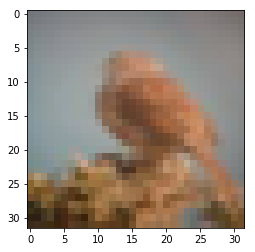

In [336]:
n = 113
if x_test.shape[-1] == 1:
    s = pp.shape
    pp = pp.reshape((s[0], s[1], s[2]))
    x_test = x_test.reshape((len(x_test), s[1], s[2]))
    
print(np.amax(x_test[n]), np.amax(pp[n]))
print(np.amin(x_test[n]), np.amin(pp[n]))
plt.imshow(x_test[n])

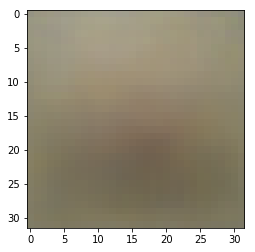

In [338]:
plt.imshow(redim(pp[n], 3))